In [1]:
import rclpy
import matplotlib.pyplot as plt
import numpy as np
from subscriber import Subscriber, sub_call

[INFO] [1726580940.122581598] [subscriber]: Received data
[INFO] [1726580940.129542003] [subscriber]: Successfully received the latest image!
[INFO] [1726580940.203679128] [subscriber]: Received data
[INFO] [1726580940.207802363] [subscriber]: Successfully received the latest image!
[INFO] [1726580940.274680028] [subscriber]: Received data
[INFO] [1726580940.283251643] [subscriber]: Successfully received the latest language!


going home


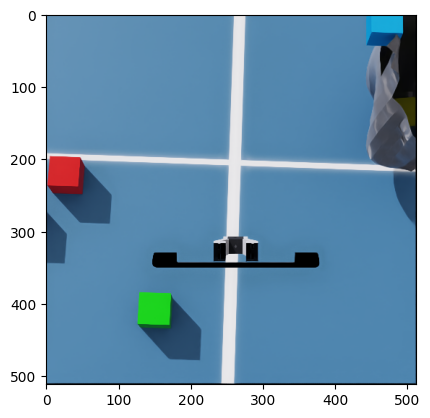

In [2]:
rclpy.init(args=None)
node = Subscriber()

image_msg = sub_call(node, '/Camera_rgb')
if image_msg:
    node.get_logger().info('Successfully received the latest image!')
    camera_image_array = np.array(image_msg.data).reshape((512, 512, 3))
    plt.imshow(camera_image_array)


image_wrist_msg = sub_call(node, '/Camera_wrist_rgb')
if image_wrist_msg:
    node.get_logger().info('Successfully received the latest image!')
    wrist_image_array = np.array(image_wrist_msg.data).reshape((512, 512, 3))
    plt.imshow(wrist_image_array)

language_msg = sub_call(node, '/language_topic')
if language_msg:
    node.get_logger().info('Successfully received the latest language!')
    print(language_msg.data)

node.destroy_node()
rclpy.shutdown()

In [3]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

/home/irobotics/anaconda3/envs/octo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Path definitions

In [4]:
PATH_CHECKPOINTS = "/media/irobotics/Transcend/finetuned_checkpoints/v4_checkpoints/"
PATH_DATASET_ROSBAG = "/media/irobotics/Transcend/isaacsim_data/v4_test/"
PATH_DATASET_TFDS = '/media/irobotics/Transcend/tensorflow_datasets/v4_test/example_dataset/1.0.0/'
PATH_INFERENCE_RESULTS = "/media/irobotics/Transcend/inference_result/"

2. Load checkpoints

In [5]:
from octo.model.octo_model import OctoModel

model = OctoModel.load_pretrained(PATH_CHECKPOINTS)

2024-09-17 16:49:16.038629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 16:49:16.038768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 16:49:16.070354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 16:49:16.908815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/irobotics/anaconda3/envs/octo/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in

3. Read test rlds datasets

In [11]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir=PATH_DATASET_TFDS)
ds = builder.as_dataset(split='train[:2]')
iterator = iter(ds)

2024-09-16 16:30:07.047720: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
episode = next(iterator)
episode

{'episode_metadata': {'file_path': <tf.Tensor: shape=(), dtype=string, numpy=b'data/train/episode_2.npy'>},
 'steps': <_VariantDataset element_spec={'action': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'observation': {'image': TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), 'state': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'wrist_image': TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>}

In [7]:
# sample episode + resize to 256x256 (default third-person cam resolution)
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]
images_wrist = [np.array(step['observation']['wrist_image']) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[100]['language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images_wrist, fps=30)

Instruction: active block selected: YellowCube


4. Run Inference

In [ ]:
# language_instruction = "pick up the yellow object and put it in the bag"

In [8]:
WINDOW_SIZE = 2

# create `task` dict
# task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(goals={"image_primary": goal_image})
task = model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [9]:
WINDOW_SIZE = 2

In [10]:
# run inference loop, this model only uses 3rd person image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    input_images_wrist = np.stack(images_wrist[step:step+WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'image_wrist': input_images_wrist,
        'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }
    
    # this returns *normalized* actions --> we need to unnormalize using the dataset statistics
    actions = model.sample_actions(
        observation, 
        task, 
        unnormalization_statistics=model.dataset_statistics["action"], 
        rng=jax.random.PRNGKey(0)
    )
    actions = actions[0] # remove batch dim

    pred_actions.append(actions)
    final_window_step = step + WINDOW_SIZE - 1
    true_actions.append(
        steps[final_window_step]['action']
    )

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [01:08<?, ?it/s]


KeyboardInterrupt: 

5. Visualize results

In [ ]:
# calculate mean squared error
pred_actions = np.stack(pred_actions)
true_actions = np.stack(true_actions)
mse = np.mean((pred_actions[:,0,:] - true_actions) ** 2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0046436963602900505


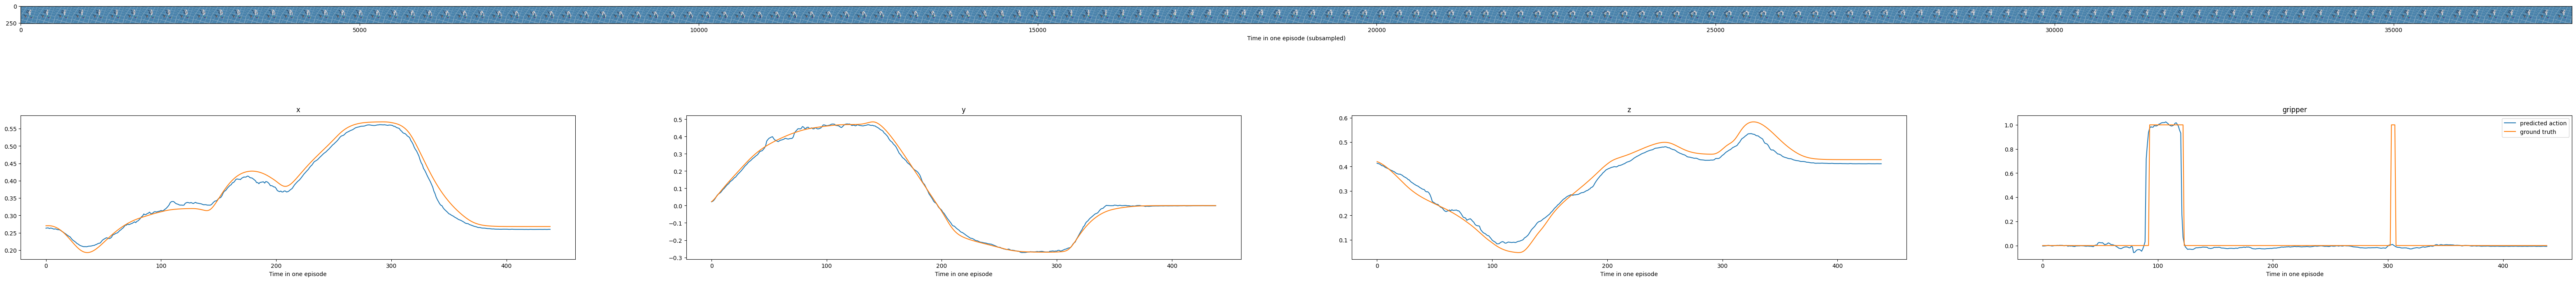

In [ ]:
import matplotlib.pyplot as plt

# ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp', "aa", "bb"]
ACTION_DIM_LABELS = ['x', 'y', 'z', 'gripper']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
    # [label] for label in ACTION_DIM_LABELS
]
# plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([80, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, action_dim shape
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()

6. Save actions numpy files

In [ ]:
np.save(PATH_INFERENCE_RESULTS + "v4_pred_actions.npy", pred_actions[:, 0, :])

In [ ]:
np.array(true_actions).shape

(439, 4)

Text(0.5, 0, 'Time in one episode (subsampled)')

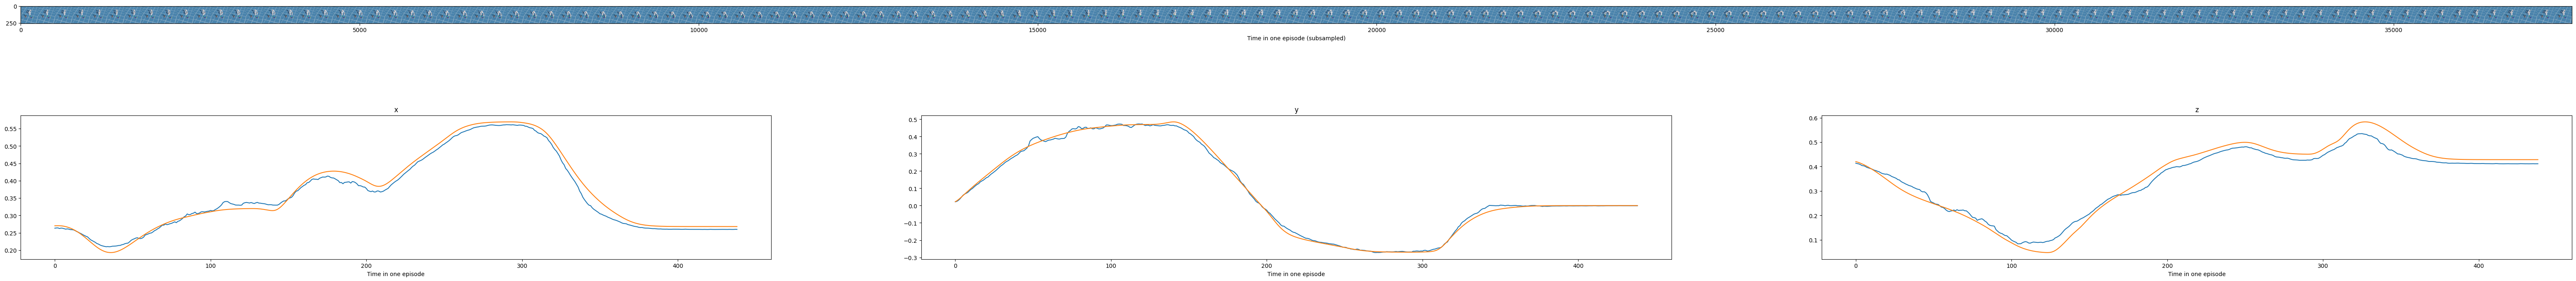

In [ ]:
# from scipy.ndimage import gaussian_filter1d
# smoothed_orange_data = []
# for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
#   smoothed_orange_data.append(np.concatenate((pred_actions[:10, 0, action_dim], gaussian_filter1d(pred_actions[10:, 0, action_dim], sigma=2)), axis=0))

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
    # [label] for label in ACTION_DIM_LABELS
]
# plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([80, 10])
# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, action_dim shape
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')